# Import and Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree
import pydot_ng as pdot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
import itertools

In [2]:
df = pd.read_csv("/home/data/MSA8010/msa8010f16t10/Oversampledata.csv")

In [3]:
df.columns

Index(['loan_status', 'loan_amnt (optional)', 'installment (optional)',
       'annual_inc (optional)', 'term', 'int_rate', 'grade', 'emp_length',
       'home_ownership', 'verification_status', 'purpose', 'addr_state',
       'dti (optional)', 'dti2 (optional)', 'total_dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'Credit History (year)'],
      dtype='object')

 # Define Features -- Convert to Numeric -- Create Matrix

In [4]:
df.drop(['loan_amnt (optional)', 'installment (optional)','annual_inc (optional)',
         'dti (optional)', 'dti2 (optional)','addr_state'], axis=1, inplace=True)

In [5]:
df.dropna(inplace=True)

In [6]:
all_features = set(df.columns)-set(['loan_status'])
num_features = set(df.describe().columns)
cat_features = all_features-num_features
print("All features:         ", ", ".join(all_features), "\nNumerical features:   ", ", ".join(num_features), "\nCategorical features: ", ", ".join(cat_features))

All features:          emp_length, revol_util, delinq_2yrs, grade, inq_last_6mths, total_dti, open_acc, home_ownership, total_acc, Credit History (year), int_rate, purpose, verification_status, revol_bal, term, pub_rec 
Numerical features:    emp_length, revol_util, delinq_2yrs, grade, inq_last_6mths, total_dti, int_rate, purpose, verification_status, open_acc, revol_bal, home_ownership, term, pub_rec, total_acc, Credit History (year), loan_status 
Categorical features:  


In [8]:
### convert to categorical variables to numeric ones
level_substitution = {}

def levels2index(levels):
    dct = {}
    for i in range(len(levels)):
        dct[levels[i]] = i
    return dct

df_num = df.copy()

for c in cat_features:
    level_substitution[c] = levels2index(df[c].unique())
    df_num[c].replace(level_substitution[c], inplace=True)

In [9]:
df_num.head()

,loan_status,term,int_rate,grade,emp_length,home_ownership,verification_status,purpose,total_dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,Credit History (year)
0,0,0,10.65,0,0,0,0,0,35.794,0,1,3,0,13648,83.7,9,31.944
1,0,1,13.66,1,4,0,1,5,40.373,0,2,17,0,17148,23.7,33,0.775
2,0,0,10.49,0,6,2,1,5,23.919,1,0,8,0,14151,87.4,16,0.450
3,0,1,15.59,5,3,2,1,5,31.929,0,0,16,0,18007,37.4,45,16.369
4,0,0,16.49,5,1,0,1,5,10.119,0,1,11,0,1619,5.0,16,0.683


In [8]:
level_substitution

{'emp_length': {'1 year': 6,
  '10+ years': 0,
  '2 years': 8,
  '3 years': 2,
  '4 years': 4,
  '5 years': 5,
  '6 years': 7,
  '7 years': 9,
  '8 years': 10,
  '9 years': 3,
  '< 1 year': 1,
  'n/a': 11},
 'grade': {'A': 2, 'B': 0, 'C': 1, 'D': 5, 'E': 3, 'F': 4, 'G': 6},
 'home_ownership': {'ANY': 5,
  'MORTGAGE': 2,
  'NONE': 4,
  'OTHER': 3,
  'OWN': 1,
  'RENT': 0},
 'purpose': {'car': 1,
  'credit_card': 0,
  'debt_consolidation': 5,
  'educational': 13,
  'home_improvement': 6,
  'house': 11,
  'major_purchase': 7,
  'medical': 8,
  'moving': 9,
  'other': 3,
  'renewable_energy': 12,
  'small_business': 2,
  'vacation': 10,
  'wedding': 4},
 'term': {' 36 months': 0, ' 60 months': 1},
 'verification_status': {'Not Verified': 2,
  'Source Verified': 1,
  'Verified': 0}}

In [10]:
### create feature matrix and target vector
X_all = df_num.drop("loan_status",axis=1).as_matrix()
X_4 = df_num[['grade','term','int_rate','total_dti']].as_matrix()
X_10 = df_num[['grade','term','int_rate','total_dti','revol_util','verification_status','purpose',
              'inq_last_6mths','home_ownership','revol_bal']].as_matrix()
y = df_num.loan_status.as_matrix()

# Modeling

#### First baseline model

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=.4, random_state=13)

In [15]:
clf = DecisionTreeClassifier(max_depth=10)
clf.fit(X_train, y_train)
ŷ = clf.predict(X_test)
print(classification_report(y_test, ŷ))

             precision    recall  f1-score   support

          0       0.66      0.69      0.67     83041
          1       0.63      0.61      0.62     74258

avg / total       0.65      0.65      0.65    157299



## Iterating

In [9]:
performance_template_df = pd.DataFrame(columns= [
        ['Params']*2 + [b for a in ['Precision', 'Recall', 'F1_score', 'Support'] for b in [a, a]],
        ['MaxDepth', 'Nfeature'] + ['no', 'yes']*4
    ])
performance_template_df

Empty DataFrame
Columns: [(Params, MaxDepth), (Params, Nfeature), (Precision, no), (Precision, yes), (Recall, no), (Recall, yes), (F1_score, no), (F1_score, yes), (Support, no), (Support, yes)]
Index: []

In [10]:
%%time
performance_df = performance_template_df.copy() #-- always start fresh

X_train1, X_test1, y_train, y_test = train_test_split(X_all, y, test_size=.4, random_state=13)
X_train2, X_test2, y_train, y_test = train_test_split(X_4, y, test_size=.4, random_state=13)
X_train3, X_test3, y_train, y_test = train_test_split(X_10, y, test_size=.4, random_state=13)

trn = [X_train1, X_train2, X_train3]
tst = [X_test1, X_test2, X_test3]
num = [16,4,10]

for dep in range(4,100,4):
    for i, j, k in zip(trn,tst,num):
        clf1 = DecisionTreeClassifier(max_depth=dep, class_weight='balanced')
        clf1.fit(i, y_train)
        ŷ1 = clf1.predict(j)
        perf_arr = None    #-- this array will hold results for different random samples
        prf1s = precision_recall_fscore_support(y_test, ŷ1)
        if type(perf_arr)!=type(None):
            perf_arr = np.vstack((perf, np.array(prf1s).reshape(1,8)))
        else:
            perf_arr = np.array(prf1s).reshape(1,8)
        perf_df = pd.concat([pd.DataFrame({'a': [dep], 'b': [k]}),
                            pd.DataFrame(perf_arr.reshape(1, 8))], axis=1, ignore_index=True)
        perf_df.columns=performance_df.columns
        performance_df = performance_df.append(perf_df, ignore_index=True)
        
        
        #print('Depth %d' % d, 'Variables ',k)
        #print(classification_report(y_test, ŷ1))

CPU times: user 1min 23s, sys: 98.3 ms, total: 1min 24s
Wall time: 1min 24s


In [43]:
performance_df

Params          Precision              Recall            F1_score  \
   MaxDepth Nfeature        no       yes        no       yes        no   
0       4.0     16.0  0.887012  0.277204  0.624317  0.644350  0.732834   
1       4.0      4.0  0.886064  0.278211  0.630073  0.637671  0.736458   
2       4.0     10.0  0.886064  0.278211  0.630073  0.637671  0.736458   
3       8.0     16.0  0.886067  0.277849  0.629062  0.638263  0.735767   
4       8.0      4.0  0.885816  0.285164  0.649271  0.625714  0.749319   
5       8.0     10.0  0.885030  0.282848  0.645743  0.624852  0.746684   
6      12.0     16.0  0.875176  0.275999  0.660593  0.578638  0.752893   
7      12.0      4.0  0.881710  0.279034  0.646272  0.612248  0.745853   
8      12.0     10.0  0.877797  0.275399  0.649621  0.595551  0.746666   
9      16.0     16.0  0.861197  0.264112  0.684259  0.506787  0.762599   
10     16.0      4.0  0.870901  0.272340  0.666554  0.558117  0.755147   
11     16.0     10.0  0.863799  0.262619  0.667819  0.529085  0.753271   
12     20.0     16.0  0.849517  0.254242  0.716283  0.432565  0.777232   
13     20.0      4.0  0.858786  0.266494  0.702481  0.483411  0.772809   
14     20.0     10.0  0.849740  0.256563  0.722028  0.429010  0.780696   
15     24.0     16.0  0.840101  0.250302  0.768192  0.346117  0.802539   
16     24.0      4.0  0.850858  0.265138  0.739528  0.420284  0.791296   
17     24.0     10.0  0.839350  0.251652  0.777695  0.334321  0.807347   
18     28.0     16.0  0.834458  0.245918  0.802529  0.288000  0.818182   
19     28.0      4.0  0.842358  0.252530  0.758051  0.365561  0.797984   
20     28.0     10.0  0.834133  0.247110  0.808635  0.280890  0.821186   
21     32.0     16.0  0.832708  0.246457  0.820041  0.263223  0.826326   
22     32.0      4.0  0.837262  0.249861  0.789233  0.313961  0.812538   
23     32.0     10.0  0.831704  0.244160  0.823871  0.254444  0.827769   
24     36.0     16.0  0.831587  0.244916  0.826930  0.251050  0.829252   
25     36.0      4.0  0.835038  0.246665  0.799386  0.293763  0.816823   
26     36.0     10.0  0.830911  0.242715  0.828158  0.246310  0.829532   
27     40.0     16.0  0.831147  0.244144  0.829375  0.246472  0.830260   
28     40.0      4.0  0.833586  0.246907  0.813056  0.274103  0.823193   
29     40.0     10.0  0.830553  0.242694  0.831784  0.241086  0.831168   
..      ...      ...       ...       ...       ...       ...       ...   
42     60.0     16.0  0.831394  0.245150  0.829411  0.247765  0.830401   
43     60.0      4.0  0.831219  0.244180  0.828737  0.247442  0.829976   
44     60.0     10.0  0.830620  0.243818  0.833891  0.239524  0.832253   
45     64.0     16.0  0.831489  0.245715  0.829857  0.247872  0.830672   
46     64.0      4.0  0.831149  0.244133  0.829327  0.246526  0.830237   
47     64.0     10.0  0.830864  0.244647  0.833446  0.241247  0.832153   
48     68.0     16.0  0.831641  0.246230  0.829628  0.248896  0.830633   
49     68.0      4.0  0.831321  0.245068  0.829929  0.246903  0.830624   
50     68.0     10.0  0.830816  0.244429  0.833398  0.241032  0.832105   
51     72.0     16.0  0.831291  0.244760  0.829459  0.247172  0.830374   
52     72.0      4.0  0.831235  0.244882  0.830314  0.246095  0.830775   
53     72.0     10.0  0.830307  0.242268  0.833277  0.238393  0.831789   
54     76.0     16.0  0.831055  0.243818  0.829483  0.245880  0.830268   
55     76.0      4.0  0.831163  0.244610  0.830363  0.245664  0.830763   
56     76.0     10.0  0.830695  0.243970  0.833506  0.240278  0.832098   
57     80.0     16.0  0.831178  0.244080  0.828905  0.247065  0.830040   
58     80.0      4.0  0.830953  0.243783  0.830423  0.244479  0.830688   
59     80.0     10.0  0.831055  0.245611  0.833867  0.241894  0.832459   
60     84.0     16.0  0.831325  0.245145  0.830073  0.246795  0.830699   
61     84.0      4.0  0.830693  0.242543  0.829953  0.243510  0.830323   
62     84.0     10.0  0.830708  0.243748  0.832819  0.240978  0.831763   
63     88

# Best Performer

In [39]:
best = performance_df.F1_score.yes.argmax()
print(performance_df.iloc[best])
#print("\nFeatures: ", ', '.join([ '"%s"'%f for f in performance_df.iloc[best].Params.Features.split('|') ], ))

Params     MaxDepth        8.000000
           Nfeature        4.000000
Precision  no              0.885816
           yes             0.285164
Recall     no              0.649271
           yes             0.625714
F1_score   no              0.749319
           yes             0.391778
Support    no          83030.000000
           yes         18566.000000
Name: 4, dtype: float64


In [11]:
clf = DecisionTreeClassifier(max_depth=8,
                            class_weight='balanced')
clf.fit(X_train2, y_train)
ŷ = clf.predict(X_test2)
print(classification_report(y_test, ŷ))

             precision    recall  f1-score   support

          0       0.89      0.65      0.75     83030
          1       0.29      0.63      0.39     18566

avg / total       0.78      0.64      0.68    101596



In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [46]:
cnf_matrix = confusion_matrix(y_test, ŷ)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[53909 29121]
 [ 6949 11617]]
Normalized confusion matrix
[[ 0.65  0.35]
 [ 0.37  0.63]]


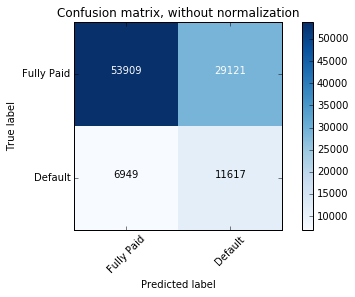

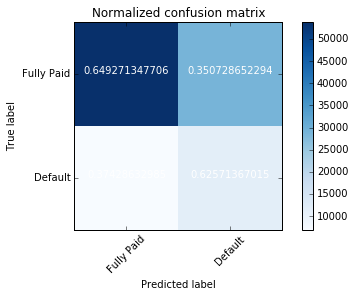

In [50]:
class_names = ['Fully Paid','Default']

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
None

### Export Tree Visualization

In [52]:
from sklearn import tree

tree.export_graphviz(clf, out_file='tree.dot')

### ROC Curve

In [41]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,ŷ, pos_label=1)

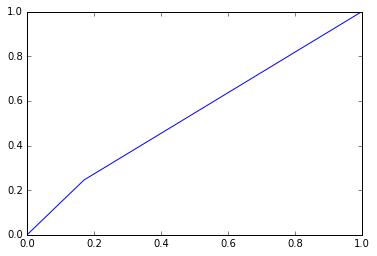

In [44]:
plt.plot(fpr,tpr)
plt.show()